<a href="https://colab.research.google.com/github/dk-wei/tensorflow-dojo/blob/main/tf_keras_classification_model_hp_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dependency

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 1.64 ms (started: 2021-08-05 22:34:23 +00:00)


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
%load_ext tensorboard

time: 1.75 s (started: 2021-08-05 22:34:23 +00:00)


In [ ]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.5.0
tensorflow.keras 2.5.0
time: 2.07 ms (started: 2021-08-05 22:34:25 +00:00)


# Load and preview Data

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

x_train_all = x_train_all / 255.0
x_test = x_test / 255.0

# 从training set拆分出val set
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)
time: 565 ms (started: 2021-08-05 22:34:25 +00:00)


In [ ]:
#x_train[0]

time: 1.06 ms (started: 2021-08-05 22:34:26 +00:00)


In [ ]:
print(np.max(x_train), np.min(x_train))

1.0 0.0
time: 63.4 ms (started: 2021-08-05 22:34:26 +00:00)


## Standardization 数据归一化/标准化

training, val和testing都需要归一化，但是都是以training的mean，std为基准

下面会用到`Batch Normalization`，就是layers每一层都会要normalization一次

In [ ]:
# x = (x-u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# x_train: [None, 28, 28] -> [None, 784] -> transform ->  [None, 28, 28]
# 每张图片先flatten到一维，归一化，再转回二维
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)   

# val和testing set直接用training set的均值和方差，所以不用fit_transform, 直接fit
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

time: 825 ms (started: 2021-08-05 22:34:26 +00:00)


In [ ]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105137
time: 34.7 ms (started: 2021-08-05 22:34:26 +00:00)


In [ ]:
# 只有一个通道的28*28黑白图片
x_train[0].shape

(28, 28)

time: 3.77 ms (started: 2021-08-05 22:34:26 +00:00)


In [ ]:
#x_train[0]

time: 688 µs (started: 2021-08-05 22:34:27 +00:00)


In [ ]:
#y_train

time: 736 µs (started: 2021-08-05 22:34:27 +00:00)


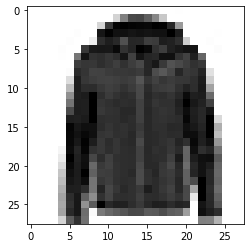

time: 163 ms (started: 2021-08-05 22:34:27 +00:00)


In [ ]:
def show_single_image(img_arr):

  # imshow可以直接打印图片
  plt.imshow(img_arr, cmap= 'binary', interpolation='nearest')
  plt.show()

show_single_image(x_train[0])

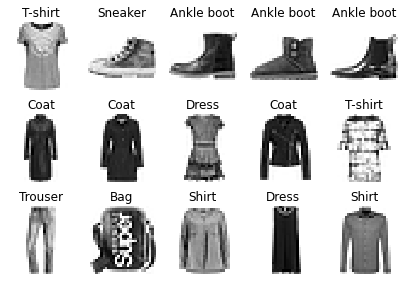

time: 477 ms (started: 2021-08-05 22:34:27 +00:00)


In [ ]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col + 1
            plt.subplot(n_rows, n_cols, index)
            plt.imshow(x_data[index], cmap='binary', interpolation='nearest')
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()
    
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Flatten(input_shape=[28,28]))
# model.output_shape

time: 1.27 ms (started: 2021-08-05 22:34:27 +00:00)


# Training

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

time: 251 ms (started: 2021-08-05 22:34:27 +00:00)


## Sklearn Wrapper

需要先装入sklearn wrapper，将keras model转变为sklearn model，然后再用sklearn的方法来做RamdomizedSearch或者别的hyper parameter tuning。

In [ ]:
# RamdomizedSearchCV (需要用到sklearn wrapper封装，转换成一个sklearn model。然后就可以直接当作sklearn model使用了)
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

# 把所有的keras model提前定义好
def build_model(hidden_layers = 2,layer_size = 50, learning_rate = 1e-3):

    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28,28]))

    for _ in range(hidden_layers - 1):
      model.add(keras.layers.Dense(layer_size, activation='relu'))
      model.add(keras.layers.BatchNormalization())

    #model.add(keras.layers.AlphaDropout(rate = 0.5))
    model.add(keras.layers.Dense(10, activation='softmax'))  # 最后一层用softmax区分度更高
    
    optimizer = keras.optimizers.Adam(learning_rate)
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy', 
                       f1_m, 
                       precision_m, 
                       recall_m
                       ])
    return model

# 再放入wrapper，就变成一个sklearn model了
sklearn_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)

time: 12.8 ms (started: 2021-08-05 22:45:47 +00:00)


In [ ]:
#model.summary()

time: 683 µs (started: 2021-08-05 22:45:48 +00:00)


In [ ]:
# 参数量w, b的由来
# [None, 784] * W + b -> [None, 300]
# W.shape = [784 * 300], b.shape = [300]

784*300+300

235500

time: 3.43 ms (started: 2021-08-05 22:45:48 +00:00)


In [ ]:
# keras.utils.plot_model(model, 
#                        show_shapes=True, 
#                        #rankdir="LR"
#                        )

time: 695 µs (started: 2021-08-05 22:45:48 +00:00)


## Callbacks

Callbacks主要是训练模型途中的一些自动化操作，最常用的一些callbacks有：
1. tensorboard  即时显示训练情况  
2. earlystopping 早停法
3. modelcheckpoint  保存(最优)模型

运行TensorBoard的方法：
在有`callbacks`文件的目录下运行


    tenforboard --logdir=callbacks

In [ ]:
# 结果一般都是保存着history这个变量里面
# 加入三种最常用的callbacks：tensorboard，earlystopping，modelcheckpoint

logdir = '/content/dnn-callbacks'
if not os.path.exists(logdir):
  os.mkdir(logdir)

output_model_file = os.path.join(logdir, 
                                 "fashion_mnist_model.h5")

callbacks = [
             keras.callbacks.TensorBoard(logdir),  # 将TensorBoard文件存在callbacks folder
             keras.callbacks.ModelCheckpoint(output_model_file,   # 将模型存在h5 file
                                             save_best_only = True),
             keras.callbacks.EarlyStopping(patience = 5,  # 设置早停
                                           min_delta = 1e-3 
             )
             
]
history = sklearn_model.fit(x_train_scaled,       
                            y_train, 
                            epochs=10, 
                            validation_data=(x_valid_scaled, y_valid),
                            callbacks = callbacks,
                            verbose=1   # 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                            )


Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5070 - accuracy: 0.8215 - f1_m: 1.5298 - precision_m: 1.5794 - recall_m: 1.5071 - val_loss: 0.3943 - val_accuracy: 0.8616 - val_f1_m: 1.3928 - val_precision_m: 1.3898 - val_recall_m: 1.3997
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3954 - accuracy: 0.8575 - f1_m: 1.3602 - precision_m: 1.3390 - recall_m: 1.3857 - val_loss: 0.3784 - val_accuracy: 0.8634 - val_f1_m: 1.3149 - val_precision_m: 1.2929 - val_recall_m: 1.3413
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3678 - accuracy: 0.8667 - f1_m: 1.3240 - precision_m: 1.2996 - recall_m: 1.3531 - val_loss: 0.3775 - val_accuracy: 0.8682 - val_f1_m: 1.3066 - val_precision_m: 1.2832 - val_recall_m: 1.3338
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3490 - accuracy: 0.8720 - f1_m: 1.3031 - precision_m: 1.2750 - recall_m: 1.3357 - val_loss: 0.3704 - val_accuracy: 0.8

In [ ]:
ls

dnn-callbacks/  model.png  sample_data/
time: 152 ms (started: 2021-08-05 22:46:47 +00:00)


In [ ]:
# 启动tensorboard

#%tensorboard --logdir=callbacks

time: 830 µs (started: 2021-08-05 22:46:47 +00:00)


In [ ]:
type(history) # history其实是一个callback

tensorflow.python.keras.callbacks.History

time: 3.38 ms (started: 2021-08-05 22:46:47 +00:00)


In [ ]:
history.epoch

history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])

time: 4.76 ms (started: 2021-08-05 22:46:47 +00:00)


# Plot Validation 

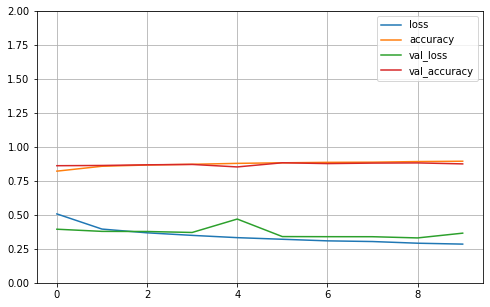

time: 231 ms (started: 2021-08-05 22:46:47 +00:00)


In [ ]:
def plot_learning_curves(history):

    # 选择需要plot的metrics，否则变量太多了
    plot_metrics = {k:v for k,v in history.history.items() if k in ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

    pd.DataFrame(plot_metrics).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 2)
    plt.show()
    
plot_learning_curves(history)

In [ ]:
#sklearn函数没有evaluate 
#model.evaluate(x_test_scaled, y_test)

time: 1.42 ms (started: 2021-08-05 22:46:47 +00:00)


# Hyper-Parameter Tuning

## RamdomizedSearchCV

创建参数搜索空间，然后开始调参

In [ ]:
from scipy.stats import reciprocal
# f(x) = 1 / (x * log(b/a)) a <= x <= b

param_distribution = {
    'hidden_layers': (1,2,3,4),
    'layer_size': tuple(np.arange(1, 10)),  # 从1取到100
    'learning_rate': reciprocal(1e-4, 1e-3),  # 随即搜索空间
}

time: 6.16 ms (started: 2021-08-05 22:46:47 +00:00)


In [ ]:
from scipy.stats import reciprocal
# f(x) = 1 / (x * log(b/a)) a <= x <= b

reciprocal.rvs(1e-4, 1e-3, size = 10)

array([0.00059141, 0.00081449, 0.00010625, 0.00093896, 0.00049386,
       0.00016337, 0.00074573, 0.00016443, 0.00052712, 0.00021075])

time: 9.14 ms (started: 2021-08-05 22:46:47 +00:00)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model, 
                                      param_distribution, 
                                      n_iter=3, # 从param_distribution里面sample出来的参数集合个数
                                      cv = 3, # cross_validation，可以修改cv的train/test比值
                                      n_jobs=1)

random_search_cv.fit(
    x_train_scaled, 
    y_train, 
    epochs = 2,
    validation_data = (x_valid_scaled, y_valid),
    callbacks=callbacks
    )

# cross_validation: 训练集分成n份，n-1训练，最后一份验证. 默认n=3
# 我们可以看到最后一轮训练是用最好的参数值训练的模型

Epoch 1/2
1146/1146 [==============================] - 6s 4ms/step - loss: 1.2364 - accuracy: 0.6290 - f1_m: 4.2170 - precision_m: 6771379.5000 - recall_m: 2.7745 - val_loss: 0.7510 - val_accuracy: 0.7890 - val_f1_m: 2.3187 - val_precision_m: 2.7567 - val_recall_m: 2.0199
Epoch 2/2
573/573 [==============================] - 2s 3ms/step - loss: 0.5879 - accuracy: 0.8058 - f1_m: 1.6716 - precision_m: 1.7332 - recall_m: 1.6221
Epoch 1/2
1146/1146 [==============================] - 6s 4ms/step - loss: 1.1797 - accuracy: 0.6558 - f1_m: 3.5703 - precision_m: 21832460.0000 - recall_m: 2.4395 - val_loss: 0.7029 - val_accuracy: 0.7812 - val_f1_m: 1.9722 - val_precision_m: 2.1973 - val_recall_m: 1.8029
Epoch 2/2
573/573 [==============================] - 2s 3ms/step - loss: 0.5615 - accuracy: 0.8156 - f1_m: 1.6296 - precision_m: 1.6914 - recall_m: 1.5797
Epoch 1/2
1146/1146 [==============================] - 6s 4ms/step - loss: 1.2840 - accuracy: 0.6199 - f1_m: 3.7699 - precision_m: 4895289.5000

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7efc6e132510>,
                   iid='deprecated', n_iter=3, n_jobs=1,
                   param_distributions={'hidden_layers': (1, 2, 3, 4),
                                        'layer_size': (1, 2, 3, 4, 5, 6, 7, 8,
                                                       9),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efc6e229d90>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

time: 3min 29s (started: 2021-08-05 22:47:48 +00:00)


3个CV，每次训练两次

In [ ]:
#plot_learning_curves(random_search_cv)

time: 6.51 ms (started: 2021-08-05 22:53:34 +00:00)


## 选取最好的模型以及其参数

In [ ]:
print(random_search_cv.best_params_)  # 最好的参数
print(random_search_cv.best_score_)   # 最好的分值
print(random_search_cv.best_estimator_) # 最好的model，可以save下来

{'hidden_layers': 3, 'layer_size': 9, 'learning_rate': 0.00032558561390169205}
0.8110910058021545
time: 2.23 ms (started: 2021-08-05 22:52:41 +00:00)


In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5109 - accuracy: 0.8243 - f1_m: 1.4306 - precision_m: 1.4271 - recall_m: 1.4382


[0.5109321475028992,
 0.8242999911308289,
 1.4305968284606934,
 1.4270997047424316,
 1.438218116760254]

time: 1.31 s (started: 2021-08-05 22:54:03 +00:00)
